# Implementation

- We will implement a K mean clustering algorithm on the wine data, which as we saw in applying PCA is well suited to be used with K Mean Clustering

# 1 - Import Libraries and dataset from SKlearn

In [ ]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and standardize
data = load_wine()

## Standarize the data for consistency

In [3]:
X = StandardScaler().fit_transform(data.data)
y = data.target

## Check for missing values

In [5]:
# Convert to DataFrame for easier inspection
df = pd.DataFrame(data.data, columns=data.feature_names)

# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

# Optional: assert that there are no missing values
assert missing.sum() == 0, "Dataset contains missing values"

Missing values per column:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


** Remarks **

- seems like we are not missing any, so we are safe to proceed to applying PCA to reduce the dimentionality of this model

# 2 - Apply PCA 

- we apply PCA to this system, which originally has 13 attributes, reducing its dimention from 13 to 2. 

In [6]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3 - Plot the dimentionally reduced wine dataset

- we will plot the wine dataset after it has been reduced 

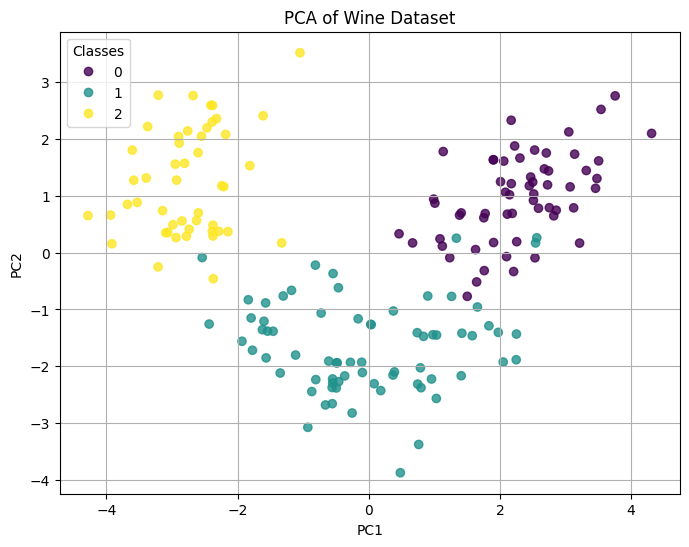

In [7]:
# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Wine Dataset')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.show()



** Remark **

- once again, we note that the dots are clustered around 3 areas, with only a few overlapse. It looks well suited for KMC and we will proceed with the model

- Lucily for us this also means we have a clear choice for K, but after running the main test we will still try other values

# 4 - Implement KMC - Defining helper functions

- we begin building our KMC analysis by defining the following functions:
Centroids Initialization function

    Distance function

    Assignmnet function

    Make classes function

    New centroid function

    Model fit function

    MSE function


In [28]:
def initialize_centroids(data, k=2):
    Centroids = []
    for _ in range(k):
        i = np.random.randint(len(data))  # Using the 2D data points
        Centroids.append(data[i, :])
    return Centroids

def distance(v, w):
    return np.sqrt(np.sum((v - w) ** 2))  # Use sum of squares for Euclidean distance

def assignment(x, Centroids):
    distances = np.array([distance(x, centroid) for centroid in Centroids])
    return np.argmin(distances)

def make_classes_indexed(data, Centroids):
    A = {i: [] for i in range(len(Centroids))}
    for idx, x in enumerate(data):
        A[assignment(x, Centroids)].append(idx)
    return A

def new_centroids(data, Centroids):
    new_Centroids = []
    A = make_classes_indexed(data, Centroids)
    for i in range(len(Centroids)):
        if len(A[i]) == 0:
            # Reinitialize centroid randomly if no points are assigned
            new_Centroids.append(data[np.random.randint(len(data))])
        else:
            cluster_points = data[A[i]]
            new_Centroids.append(np.mean(cluster_points, axis=0))
    return new_Centroids


def fit(data, k=3, max_iterations=100, epsilon=0.01):
    C_old = initialize_centroids(data, k=k)  # Initialize centroids
    C_new = new_centroids(data, C_old)  # Update centroids
    
    centroid_distances = [distance(p[0], p[1]) for p in zip(C_old, C_new)]  # Check centroid movement
    iterations = 0
    
    # Iterate until centroids don't move significantly or max iterations is reached
    while max(centroid_distances) > epsilon and iterations < max_iterations:
        C_old, C_new = C_new, new_centroids(data, C_new)  # Update centroids
        centroid_distances = [distance(p[0], p[1]) for p in zip(C_old, C_new)]
        iterations += 1
        
    return C_new  # Return the final centroids

def mse_classes(data, Centroids):
    errors = []
    A_classes = make_classes_indexed(data, Centroids)
    for i, centroid in enumerate(Centroids):
        error = sum(0.5*(centroid - a) @ (centroid - a) for a in A_classes[i])
        errors.append(error)
        
    return sum(x for x in errors)


# 5 - Fit KMC model

- we fit the reduced data to a KMC model with K = 3

In [29]:
# Fit the model with your own K-Means implementation
final_centroids = fit(X, k=3)

clusters = make_classes_indexed(X, final_centroids)
y_custom = np.zeros(len(X), dtype=int)
for cluster_id, indices in clusters.items():
    y_custom[indices] = cluster_id


# 6 - Plotting Decision Region

- we plot the resulting classification and decision boundary and region from the resulting model

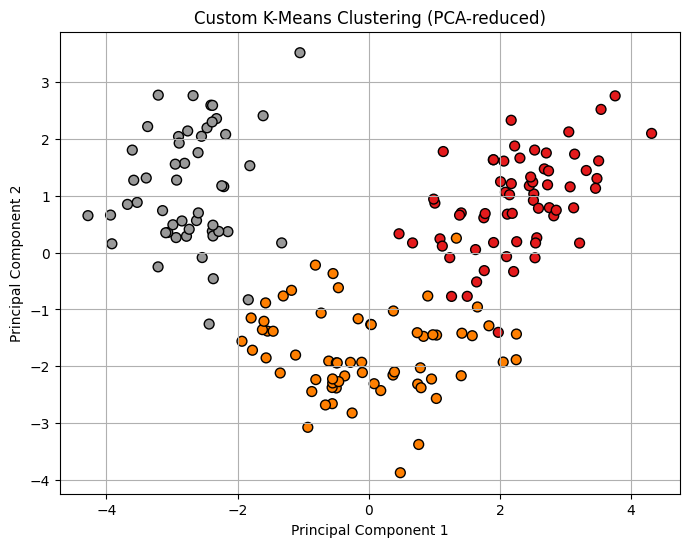

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_custom, cmap='Set1', edgecolor='k', s=50)
plt.title("Custom K-Means Clustering (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


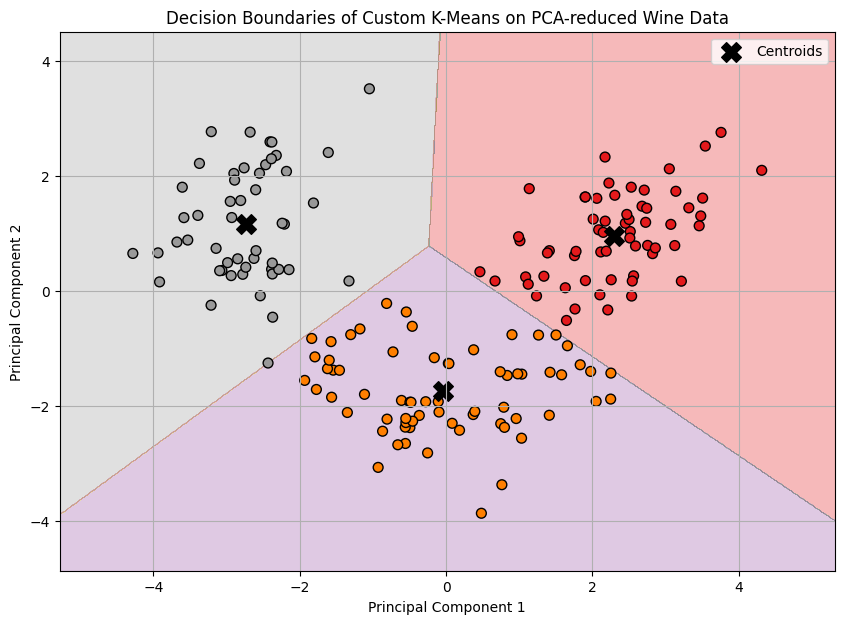

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Run K-Means on PCA-reduced data
final_centroids_pca = fit(X_pca, k=3)

# Step 3: Label each point
clusters_pca = make_classes_indexed(X_pca, final_centroids_pca)
y_custom_pca = np.zeros(len(X_pca), dtype=int)
for cluster_id, indices in clusters_pca.items():
    y_custom_pca[indices] = cluster_id

# Step 4: Build mesh grid for decision boundary
h = 0.01  # step size
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict cluster label for each point in mesh
Z = np.c_[xx.ravel(), yy.ravel()]
Z_labels = np.array([assignment(z, final_centroids_pca) for z in Z])
Z_labels = Z_labels.reshape(xx.shape)

# Step 5: Plot decision boundary and PCA scatter
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z_labels, alpha=0.3, cmap='Set1')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_custom_pca, cmap='Set1', edgecolor='k', s=50)
plt.scatter(*np.array(final_centroids_pca).T, c='black', marker='X', s=200, label='Centroids')
plt.title("Decision Boundaries of Custom K-Means on PCA-reduced Wine Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


** Remark **

- Seems very reasonable, and captures most of the data in their correct classification.

- we will now empirically calculate the performance metrics of this model

# 7 - Calculateing Rand score and Silhouette score

In [19]:

# Evaluation against true labels (for academic benchmarking)
ari = adjusted_rand_score(y, y_custom)
print(f"Adjusted Rand Index: {ari:.3f}")

# Internal metric: silhouette score
sil_score = silhouette_score(X, y_custom)
print(f"Silhouette Score: {sil_score:.3f}")


Adjusted Rand Index: 0.897
Silhouette Score: 0.285


** Remarks **

- These are some very meaningful metrics about our KMC mode, namely that: 

    - An ARI of 0.897 is very high, especially in an unsupervised context, meaning that our clusters closely matches the actual wine class labels, even though the algorithm had no access to them. This suggests that the true class structure aligns well with separable clusters in feature space.

    - Silhouette Score: 0.285, which is modest. It implies that while clusters exist and are distinguishable, they aren’t very compact or well-separated. We can infer this was most likely due to the existence of the few outliers that was deep in another boundary. Without those this model would have performed even better

# 7 - Confirming optimal k with elbow method plot

- here we seek to confirm our choice of k=3 was indeed the optimal choice, or if better k values exist. We will plot the elbow plot and look for the point where inertia stops dropping rapidly

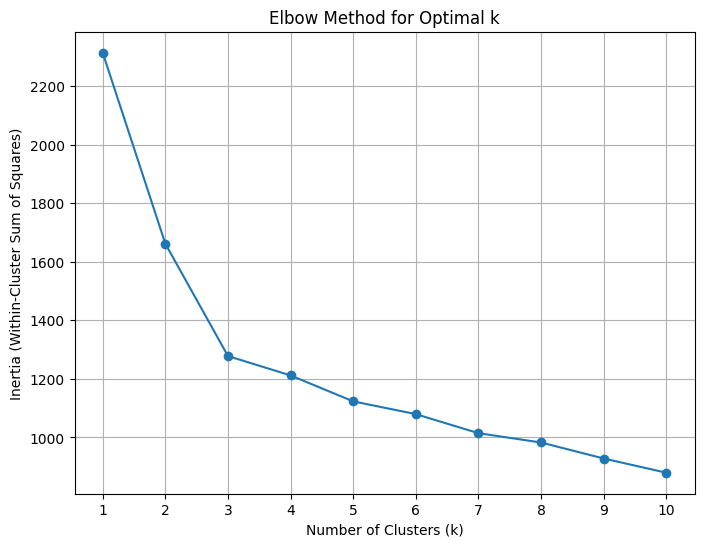

In [21]:
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,6))
plt.plot(k_range, inertias, marker='o')
plt.xticks(k_range)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()


** Remarks **

- Looks like our choice of k = 3 was indeed the optimal k, where inertia stablized into a linear decline. This makes sense given we knew we had 3 clusters to begin with. 

# Conclusion 

- We confirmed our observation from before, and this dataset is indeed well suited to be used with a K Means Clustering algorithm. The resulting model had a high accuracy in classifying entries, although the cluster's tightness was compromised by the existence of a few outliers. 

- We can see that KMC is very well suited for datasets that have visually seperateble clusters either directly or through PCA.